<a href="https://colab.research.google.com/github/NandithaSHadligere/CulturalHeritage/blob/main/HeritageAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

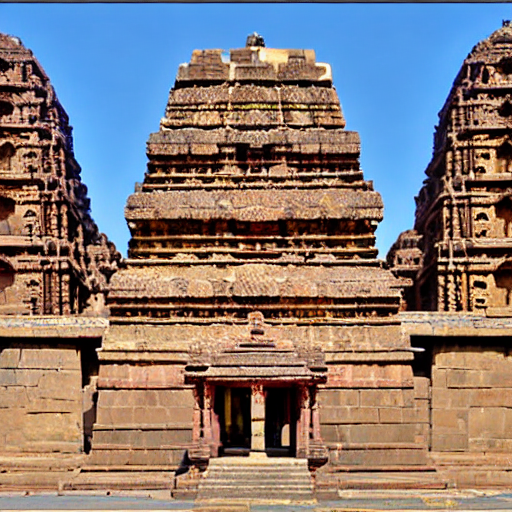

In [1]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import display  # To display images in Jupyter Notebook

# Load the pre-trained Stable Diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

# Function to generate an image
def generate_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        image = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    return image

# Example usage
prompt = "Konarak temple"
image = generate_image(prompt)

# Display the image in Jupyter Notebook
display(image)

# Save the generated image
image.save("sun_temple.png")


  0%|          | 0/50 [00:00<?, ?it/s]

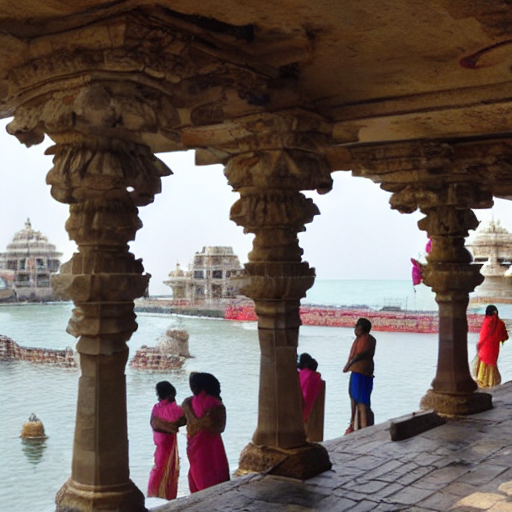

In [2]:

# Example usage
prompt = "Dwarka temple"
image = generate_image(prompt)

# Display the image in Jupyter Notebook
display(image)

# Save the generated image
image.save("shree-krishna_temple.png")

Step 1: Generate Depth Map

In [14]:
import torch
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Load MiDaS model
midas_model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas_model.eval()
midas_model.to("cuda")

# Load transforms to prepare the image for the model
transform = Compose([
    Resize(384),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def estimate_depth(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_input = transform(img).unsqueeze(0).to("cuda")

    with torch.no_grad():
        depth = midas_model(img_input)
        depth = depth.squeeze().cpu().numpy()

    depth_min = depth.min()
    depth_max = depth.max()
    depth_normalized = (depth - depth_min) / (depth_max - depth_min)

    return depth_normalized

# Estimate depth
depth_map = estimate_depth("sun_temple.png")
cv2.imwrite("depth_map.png", depth_map * 255)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Step 2: Create 3D Mesh

In [ ]:
import open3d as o3d
import numpy as np

def create_mesh_from_depth_map(depth_map_path, image_path):
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(image_path)

    h, w = depth_map.shape
    fx = fy = 1.0
    cx, cy = w / 2, h / 2

    # Create point cloud
    points = []
    colors = []
    for v in range(h):
        for u in range(w):
            z = depth_map[v, u] / 255.0
            if z > 0:
                x = (u - cx) * z / fx
                y = (v - cy) * z / fy
                points.append([x, y, z])
                colors.append(image[v, u] / 255.0)

    points = np.array(points)
    colors = np.array(colors)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    # Create mesh
    distances = point_cloud.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 3 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        point_cloud, o3d.utility.DoubleVector([radius, radius * 2])
    )

    mesh.compute_vertex_normals()

    return mesh

# Create 3D mesh
mesh = create_mesh_from_depth_map("depth_map.png", "sun_temple.png")
o3d.io.write_triangle_mesh("sun_temple_3d.ply", mesh)

In [ ]:
pip install open3d


In [ ]:
import open3d as o3d

# Load the 3D mesh from the .ply file
mesh = o3d.io.read_triangle_mesh("sun_temple_3d.ply")

# Visualize the 3D mesh
o3d.visualization.draw_geometries([mesh])